In [1]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50
from efficientnet.tfkeras import EfficientNetB3
from keras.applications import InceptionV3
from keras.applications import MobileNetV2
from keras.applications import NASNetMobile
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from keras.applications import Xception




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Data

In [4]:
batikTrain = "/content/drive/MyDrive/Batik/raw_batik_v2.1/train"
batikVal = "/content/drive/MyDrive/Batik/raw_batik_v2.1/test"

## EDA

### Checking Format & total images in all directory

In [ ]:
import imghdr

def count_images_and_formats(directory):
    formats = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_extension = os.path.splitext(file)[1].lower()
            if file_extension in formats:
                formats[file_extension] += 1
            else:
                formats[file_extension] = 1
    total_images = sum(formats.values())
    return total_images, formats

# Count the number of images and their formats
train_image_count, train_formats = count_images_and_formats(batikTrain)
val_image_count, val_formats = count_images_and_formats(batikVal)

# Display the total number of images and their formats
print("Total number of training images: ", train_image_count)
print("Training image formats: ", train_formats)
print("Total number of testing images: ", val_image_count)
print("Testing image formats: ", val_formats)

Total number of training images:  480
Training image formats:  {'.jpg': 480}
Total number of testing images:  120
Testing image formats:  {'.jpg': 120}


### Distribution of images in Training and validation sets

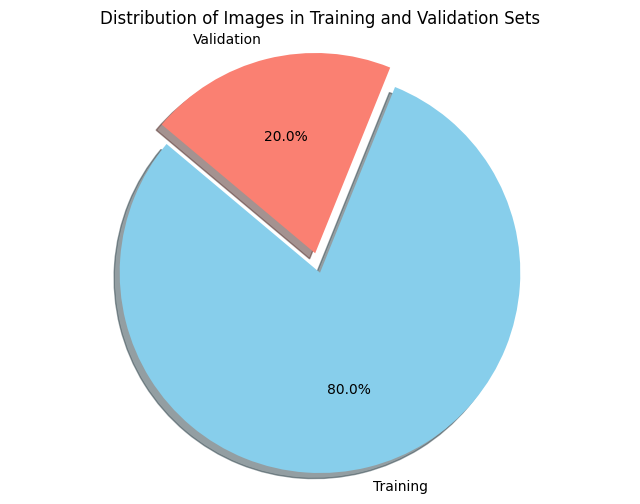

In [ ]:
import matplotlib.pyplot as plt

# Total number of images in training and validation sets
total_train_images = train_image_count
total_val_images = val_image_count

# Calculate percentages
train_percent = (total_train_images / (total_train_images + total_val_images)) * 100
val_percent = (total_val_images / (total_train_images + total_val_images)) * 100

# Plotting
labels = ['Training', 'Validation']
sizes = [train_percent, val_percent]
colors = ['skyblue', 'salmon']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Images in Training and Validation Sets')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Total number of images in Validation Class

In [ ]:
def count_images_in_each_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([file for file in os.listdir(class_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
    return class_counts

# Directory to be analyzed
directory = batikVal

# Count the number of images in each class
class_counts = count_images_in_each_class(directory)

# Display the number of images in each class
print('List Of All Class :')
for class_name, count in class_counts.items():
    print('===================')
    print(f"'{class_name}': {count}")

List Of All Class :
'Papua_Asmat': 8
'SulawesiSelatan_Lontara': 8
'Papua_Cendrawasih': 8
'Solo_Parang': 8
'Papua_Tifa': 8
'Yogyakarta_Kawung': 8
'SumateraUtara_Boraspati': 8
'Bali_Merak': 8
'DKI_Ondel_Ondel': 8
'Maluku_Pala': 8
'Kalimantan_Dayak': 8
'Bali_Barong': 8
'JawaTimur_Pring': 8
'JawaBarat_Megamendung': 8
'Madura_Mataketeran': 8


### Total number of images in Train Class

In [ ]:
def count_images_in_each_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([file for file in os.listdir(class_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
    return class_counts

# Directory to be analyzed
directory = batikTrain

# Count the number of images in each class
class_counts = count_images_in_each_class(directory)

# Display the number of images in each class
print('List Of All Class :')
for class_name, count in class_counts.items():
    print('===================')
    print(f"'{class_name}': {count}")

List Of All Class :
'Papua_Cendrawasih': 32
'Papua_Asmat': 32
'Yogyakarta_Kawung': 32
'SulawesiSelatan_Lontara': 32
'Solo_Parang': 32
'SumateraUtara_Boraspati': 32
'Papua_Tifa': 32
'Maluku_Pala': 32
'Bali_Merak': 32
'JawaBarat_Megamendung': 32
'DKI_Ondel_Ondel': 32
'Madura_Mataketeran': 32
'JawaTimur_Pring': 32
'Bali_Barong': 32
'Kalimantan_Dayak': 32


## Data Augmentation & generator

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

#Train
train_gen = train_datagen.flow_from_directory(
                                            batikTrain,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                            )

#Validation
val_gen = val_datagen.flow_from_directory(
                                            batikVal,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )
#Test
test_gen = test_datagen.flow_from_directory(
                                            batikVal,
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='categorical',
                                                )

Found 480 images belonging to 15 classes.
Found 120 images belonging to 15 classes.
Found 120 images belonging to 15 classes.


###CheckPointCallBack

In [7]:
checkpoint_callback = ModelCheckpoint(
    filepath='raw_batik_v2.1_Inception_{epoch:02d}.h5',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)


## EfficientNetB3 model

In [8]:
pre_train_EfficientNetB3 = EfficientNetB3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

44107200/44107200 [==============================] - 1s 0us/step


In [ ]:
pre_train_EfficientNetB3.trainable = False

In [ ]:

model_ENB3 = tf.keras.Sequential([
    pre_train_EfficientNetB3,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [ ]:
model_ENB3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 100
verb = 1

history = model_ENB3.fit(
            train_gen ,
            validation_data = val_gen,
            epochs = epoch,
            verbose = verb,
            callbacks=[checkpoint_callback])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 2.2010 - accuracy: 0.3292 
Epoch 1: saving model to raw_batik_v2.1_EfficientNetB3_epoch_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 449s 30s/step - loss: 2.2010 - accuracy: 0.3292 - val_loss: 1.2658 - val_accuracy: 0.7083
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 1.1276 - accuracy: 0.6833
Epoch 2: saving model to raw_batik_v2.1_EfficientNetB3_epoch_02.h5
15/15 [==============================] - 16s 1s/step - loss: 1.1276 - accuracy: 0.6833 - val_loss: 0.8486 - val_accuracy: 0.7583
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 0.7934 - accuracy: 0.7625
Epoch 3: saving model to raw_batik_v2.1_EfficientNetB3_epoch_03.h5
15/15 [==============================] - 15s 1s/step - loss: 0.7934 - accuracy: 0.7625 - val_loss: 0.6198 - val_accuracy: 0.8500
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.8479
Epoch 4: saving model to raw_batik_v2.1_EfficientNetB3_epoch_04.h5
15/15 [==============================] - 15s 1s/step - loss: 0.5711 - accuracy: 0.8479 - val_loss: 0.5052 - val_accuracy: 0.8

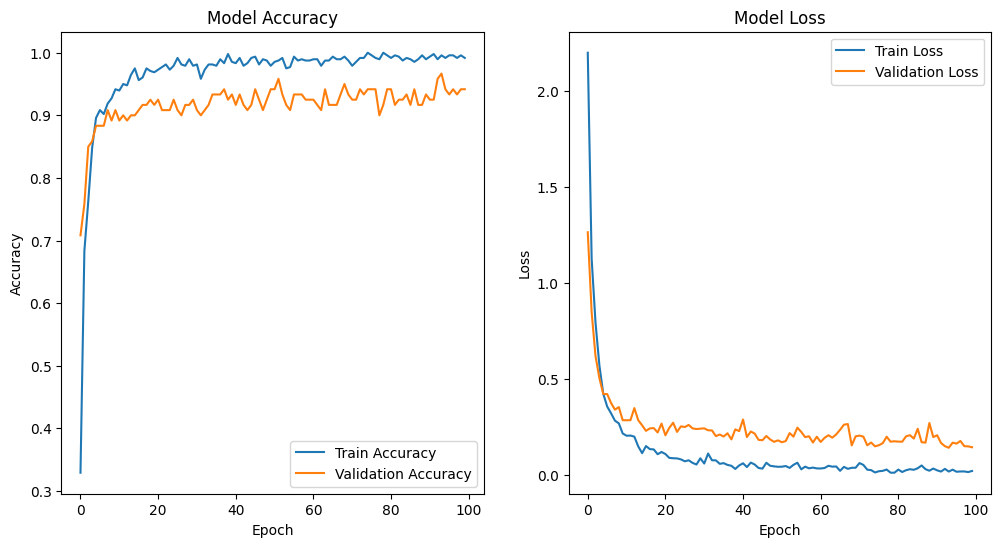

In [ ]:
def plot_metrics(history):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.show()


plot_metrics(history)

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_ENB3
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

            Bali_Barong       0.89      1.00      0.94         8
             Bali_Merak       0.89      1.00      0.94         8
        DKI_Ondel_Ondel       0.89      1.00      0.94         8
  JawaBarat_Megamendung       1.00      1.00      1.00         8
        JawaTimur_Pring       1.00      1.00      1.00         8
       Kalimantan_Dayak       0.89      1.00      0.94         8
     Madura_Mataketeran       1.00      0.88      0.93         8
            Maluku_Pala       1.00      0.88      0.93         8
            Papua_Asmat       0.89      1.00      0.94         8
      Papua_Cendrawasih       0.88      0.88      0.88         8
             Papua_Tifa       1.00      0.62      0.77         8
            Solo_Parang       1.00      1.00      1.00         8
SulawesiSelatan_Lontara       1.00      1.00      1.00         8
SumateraUtara_Boraspati       0.88      0.88      0.88         8
      Yogyakarta_Kawung 

### Best Classification EfficientNetB3

In [ ]:
model_ENB3_BEST = load_model('/content/raw_batik_v2.1_EfficientNetB3_epoch_94.h5')

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_ENB3_BEST
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

            Bali_Barong       1.00      1.00      1.00         8
             Bali_Merak       1.00      1.00      1.00         8
        DKI_Ondel_Ondel       0.89      1.00      0.94         8
  JawaBarat_Megamendung       1.00      1.00      1.00         8
        JawaTimur_Pring       1.00      1.00      1.00         8
       Kalimantan_Dayak       0.89      1.00      0.94         8
     Madura_Mataketeran       1.00      0.88      0.93         8
            Maluku_Pala       1.00      0.88      0.93         8
            Papua_Asmat       1.00      1.00      1.00         8
      Papua_Cendrawasih       0.88      0.88      0.88         8
             Papua_Tifa       1.00      0.88      0.93         8
            Solo_Parang       0.89      1.00      0.94         8
SulawesiSelatan_Lontara       1.00      1.00      1.00         8
SumateraUtara_Boraspati       1.00      1.00      1.00         8
      Yogyakarta_Kawung 

### EfficientNetB3 Model predict test

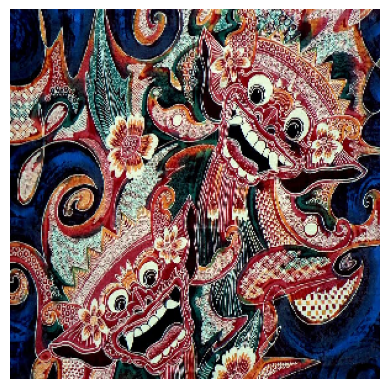

1/1 [==============================] - 0s 46ms/step
Correct Class : Bali_Barong 
Predicted Label: Bali_Barong


In [ ]:
from keras.preprocessing import image
img_target = '/content/interesting-barong-motifs-on-the-batiks-bali-glimpses-of-the-world.jpg'

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : Bali_Barong ")
print(f"Predicted Label: {class_names[img_pred]}")

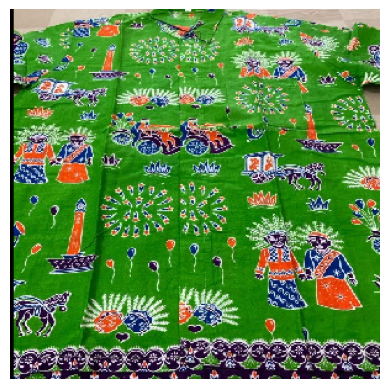

1/1 [==============================] - 0s 40ms/step
Correct Class : DKI_Ondel_Ondel 
Predicted Label: DKI_Ondel_Ondel


In [ ]:
img_target = '/content/harusnya-ondelondel.jpg'

model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : DKI_Ondel_Ondel ")
print(f"Predicted Label: {class_names[img_pred]}")

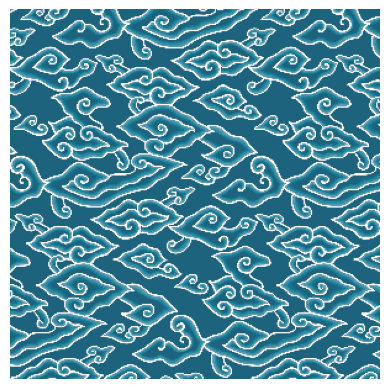

1/1 [==============================] - 0s 38ms/step
Correct Class : JawaBarat_Megamendung 
Predicted Label: JawaBarat_Megamendung


In [ ]:
img_target = '/content/harusnya-megamendung.jpg'

model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : JawaBarat_Megamendung ")
print(f"Predicted Label: {class_names[img_pred]}")

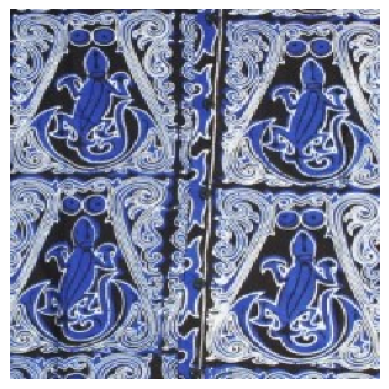

1/1 [==============================] - 0s 57ms/step
Correct Class : SumateraUtara_Boraspati 
Predicted Label: SumateraUtara_Boraspati


In [ ]:
img_target = '/content/harusnya-boraspati.jpg'

model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : SumateraUtara_Boraspati ")
print(f"Predicted Label: {class_names[img_pred]}")

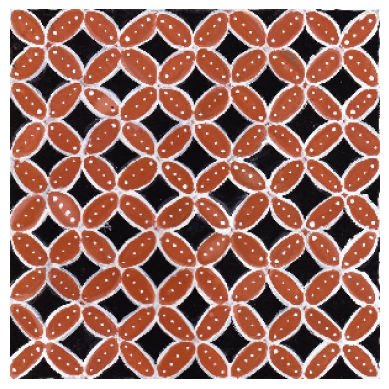

1/1 [==============================] - 0s 64ms/step
Correct Class : Yogyakarta_Kawung 
Predicted Label: Yogyakarta_Kawung


In [ ]:
img_target = '/content/harusnya-kawung.jpg'

model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : Yogyakarta_Kawung ")
print(f"Predicted Label: {class_names[img_pred]}")

## InceptionV3 model

In [9]:
pre_train_InceptionV3 = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

87910968/87910968 [==============================] - 3s 0us/step


In [10]:
pre_train_InceptionV3.trainable = False

In [11]:

model_INCV3 = tf.keras.Sequential([
    pre_train_InceptionV3,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [12]:
model_INCV3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
epoch = 100
verb = 1

history_INCV3 = model_INCV3.fit(
            train_gen ,
            validation_data = val_gen,
            epochs = epoch,
            verbose = verb,
            callbacks=[checkpoint_callback])

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 2.9003 - accuracy: 0.0896 
Epoch 1: saving model to raw_batik_v2.1_Inception_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 346s 22s/step - loss: 2.9003 - accuracy: 0.0896 - val_loss: 2.3655 - val_accuracy: 0.3333
Epoch 2/100
15/15 [==============================] - ETA: 0s - loss: 2.3982 - accuracy: 0.2583
Epoch 2: saving model to raw_batik_v2.1_Inception_02.h5
15/15 [==============================] - 9s 635ms/step - loss: 2.3982 - accuracy: 0.2583 - val_loss: 2.0400 - val_accuracy: 0.4833
Epoch 3/100
15/15 [==============================] - ETA: 0s - loss: 2.0915 - accuracy: 0.3688
Epoch 3: saving model to raw_batik_v2.1_Inception_03.h5
15/15 [==============================] - 9s 587ms/step - loss: 2.0915 - accuracy: 0.3688 - val_loss: 1.8041 - val_accuracy: 0.5667
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 1.8636 - accuracy: 0.4062
Epoch 4: saving model to raw_batik_v2.1_Inception_04.h5
15/15 [==============================] - 10s 658ms/step - loss: 1.8636 - accuracy: 0.4062 - val_loss: 1.6226 - val_accuracy: 0.6333
Epoch 5/100
15/15 [===

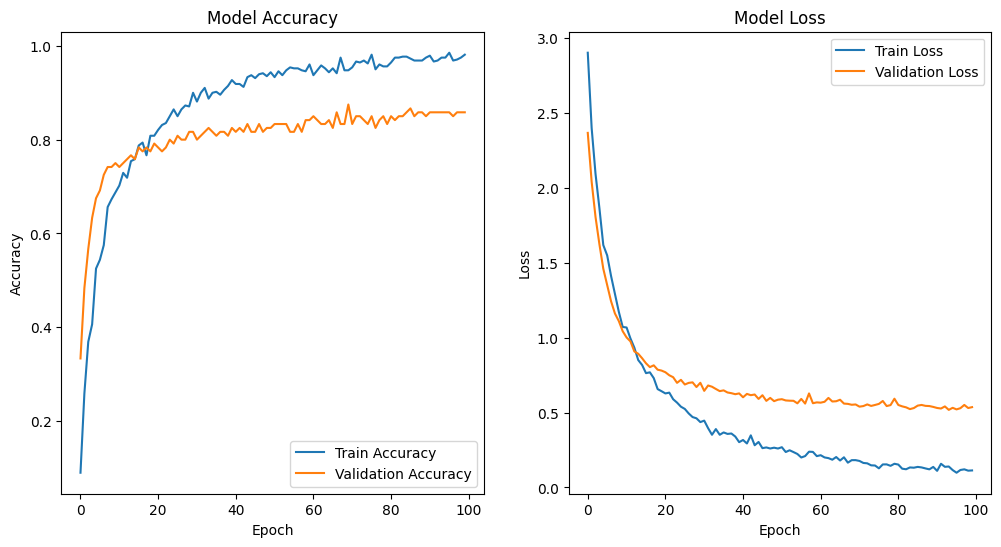

In [16]:
def plot_metrics(history_INCV3):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history_INCV3.history['accuracy'], label='Train Accuracy')
    plt.plot(history_INCV3.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_INCV3.history['loss'], label='Train Loss')
    plt.plot(history_INCV3.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.show()


plot_metrics(history_INCV3)

### Classification Report Model

In [17]:
from sklearn.metrics import classification_report

class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_INCV3
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

            Bali_Barong       0.89      1.00      0.94         8
             Bali_Merak       0.80      1.00      0.89         8
        DKI_Ondel_Ondel       1.00      0.75      0.86         8
  JawaBarat_Megamendung       1.00      1.00      1.00         8
        JawaTimur_Pring       0.89      1.00      0.94         8
       Kalimantan_Dayak       1.00      1.00      1.00         8
     Madura_Mataketeran       0.60      0.38      0.46         8
            Maluku_Pala       0.80      1.00      0.89         8
            Papua_Asmat       0.80      1.00      0.89         8
      Papua_Cendrawasih       0.83      0.62      0.71         8
             Papua_Tifa       0.62      0.62      0.62         8
            Solo_Parang       0.89      1.00      0.94         8
SulawesiSelatan_Lontara       0.88      0.88      0.88         8
SumateraUtara_Boraspati       0.83      0.62      0.71         8
      Yogyakarta_Kawung 

#### Best Classification INCEPTION V3

In [20]:
model_INCV3_BEST = load_model('/content/raw_batik_v2.1_Inception_70.h5')

In [21]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_INCV3_BEST
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

            Bali_Barong       0.89      1.00      0.94         8
             Bali_Merak       0.89      1.00      0.94         8
        DKI_Ondel_Ondel       1.00      0.75      0.86         8
  JawaBarat_Megamendung       1.00      0.88      0.93         8
        JawaTimur_Pring       0.89      1.00      0.94         8
       Kalimantan_Dayak       1.00      1.00      1.00         8
     Madura_Mataketeran       0.62      0.62      0.62         8
            Maluku_Pala       0.89      1.00      0.94         8
            Papua_Asmat       0.80      1.00      0.89         8
      Papua_Cendrawasih       0.83      0.62      0.71         8
             Papua_Tifa       0.83      0.62      0.71         8
            Solo_Parang       0.89      1.00      0.94         8
SulawesiSelatan_Lontara       0.88      0.88      0.88         8
SumateraUtara_Boraspati       0.75      0.75      0.75         8
      Yogyakarta_Kawung 

### InceptionV3 Model predict test

In [24]:
#input model
model_input = model_INCV3_BEST

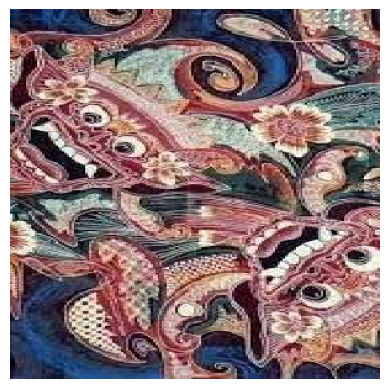

1/1 [==============================] - 3s 3s/step
Correct Class : Bali_Barong 
Predicted Label: Bali_Barong


In [25]:
from keras.preprocessing import image
img_target = '/content/Batik_Barong.jpg'

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : Bali_Barong ")
print(f"Predicted Label: {class_names[img_pred]}")

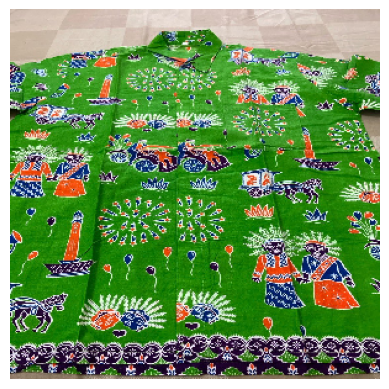

1/1 [==============================] - 0s 76ms/step
Correct Class : DKI_Ondel_Ondel 
Predicted Label: DKI_Ondel_Ondel


In [26]:
img_target = '/content/Batik_Ondel.jpg'



img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : DKI_Ondel_Ondel ")
print(f"Predicted Label: {class_names[img_pred]}")

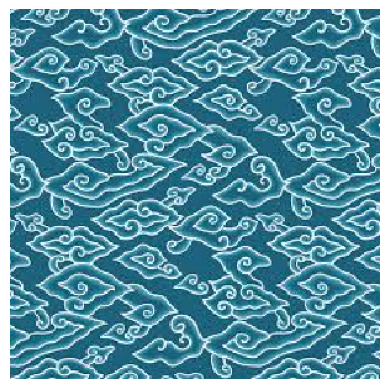

1/1 [==============================] - 0s 43ms/step
Correct Class : JawaBarat_Megamendung 
Predicted Label: JawaBarat_Megamendung


In [28]:
img_target = '/content/Batik_Megamendung.jpg'



img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : JawaBarat_Megamendung ")
print(f"Predicted Label: {class_names[img_pred]}")

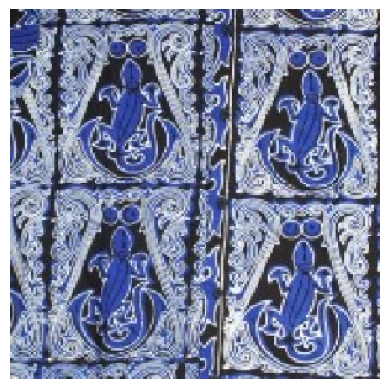

1/1 [==============================] - 0s 45ms/step
Correct Class : SumateraUtara_Boraspati 
Predicted Label: SumateraUtara_Boraspati


In [29]:
img_target = '/content/Batik_Boraspati.jpg'



img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : SumateraUtara_Boraspati ")
print(f"Predicted Label: {class_names[img_pred]}")

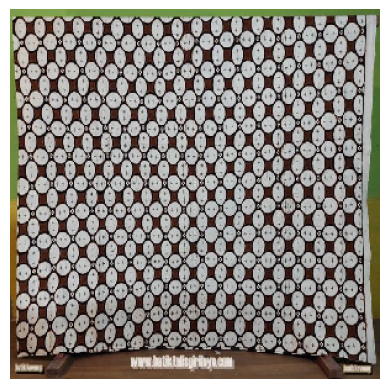

1/1 [==============================] - 0s 102ms/step
Correct Class : Yogyakarta_Kawung 
Predicted Label: Yogyakarta_Kawung


In [30]:
img_target = '/content/batik-kawung.jpg'



img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : Yogyakarta_Kawung ")
print(f"Predicted Label: {class_names[img_pred]}")

## Xception model

In [ ]:
pre_train_Xception = Xception(
    input_shape=(299,  299, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)

In [ ]:
pre_train_Xception.trainable = False

In [ ]:

model_Xception = tf.keras.Sequential([
    pre_train_Xception,
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(15, activation='softmax')
])

In [ ]:
model_Xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch = 90
verb = 1

history = model_Xception.fit(
            train_gen ,
            validation_data = val_gen,
            epochs = epoch,
            verbose = verb,
            callbacks=[checkpoint_callback])

Epoch 1/90
15/15 [==============================] - ETA: 0s - loss: 2.6764 - accuracy: 0.1271
Epoch 1: saving model to raw_batik_v2.1_Xception_epoch_01.h5
15/15 [==============================] - 21s 1s/step - loss: 2.6764 - accuracy: 0.1271 - val_loss: 2.4647 - val_accuracy: 0.3167
Epoch 2/90
15/15 [==============================] - ETA: 0s - loss: 2.3939 - accuracy: 0.3292
Epoch 2: saving model to raw_batik_v2.1_Xception_epoch_02.h5
15/15 [==============================] - 16s 1s/step - loss: 2.3939 - accuracy: 0.3292 - val_loss: 2.2293 - val_accuracy: 0.4917
Epoch 3/90
15/15 [==============================] - ETA: 0s - loss: 2.1721 - accuracy: 0.4396
Epoch 3: saving model to raw_batik_v2.1_Xception_epoch_03.h5
15/15 [==============================] - 17s 1s/step - loss: 2.1721 - accuracy: 0.4396 - val_loss: 2.0128 - val_accuracy: 0.6000
Epoch 4/90
15/15 [==============================] - ETA: 0s - loss: 1.9595 - accuracy: 0.5646
Epoch 4: saving model to raw_batik_v2.1_Xception_epoch

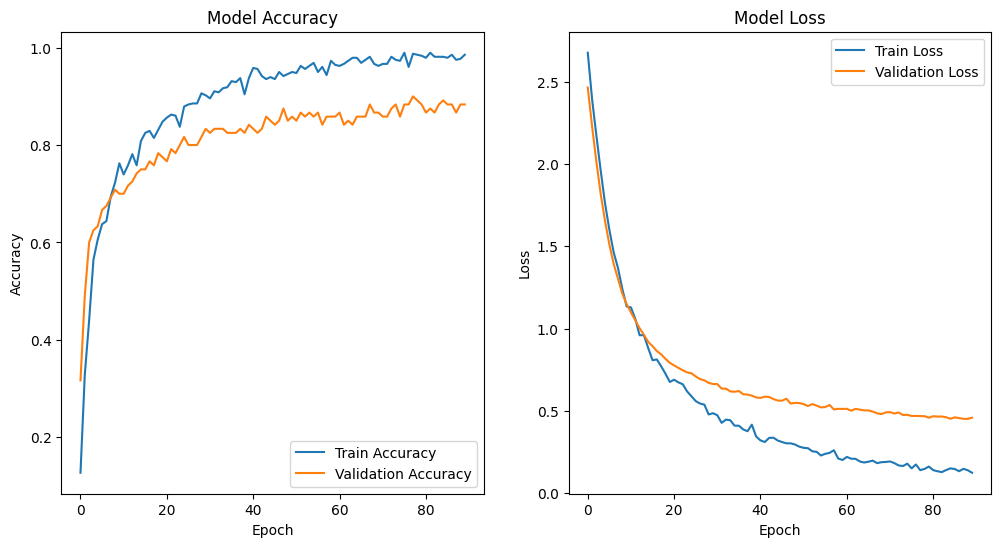

In [ ]:
def plot_metrics(history):

    plt.figure(figsize=(12, 6))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.show()


plot_metrics(history)

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_Xception
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

            Bali_Barong       0.88      0.88      0.88         8
             Bali_Merak       0.88      0.88      0.88         8
        DKI_Ondel_Ondel       0.86      0.75      0.80         8
  JawaBarat_Megamendung       1.00      0.88      0.93         8
        JawaTimur_Pring       0.88      0.88      0.88         8
       Kalimantan_Dayak       1.00      1.00      1.00         8
     Madura_Mataketeran       0.86      0.75      0.80         8
            Maluku_Pala       0.73      1.00      0.84         8
            Papua_Asmat       0.88      0.88      0.88         8
      Papua_Cendrawasih       1.00      0.75      0.86         8
             Papua_Tifa       0.83      0.62      0.71         8
            Solo_Parang       0.89      1.00      0.94         8
SulawesiSelatan_Lontara       0.89      1.00      0.94         8
SumateraUtara_Boraspati       0.80      1.00      0.89         8
      Yogyakarta_Kawung 

### Best Classification Xception

In [ ]:
model_Xception_BEST = load_model('/content/raw_batik_v2.1_Xception_epoch_78.h5')

In [ ]:
class_names = list(val_gen.class_indices.keys())

y_test = []
y_pred = []
model_names = model_Xception_BEST
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen.next()

    for j in range(len(y_batch)):

        y_test.append(class_names[tf.argmax(y_batch[j]).numpy()])

        prediction = model_names.predict(x_batch[j][None, ...], verbose=0)
        y_pred.append(class_names[np.argmax(prediction)])


print(classification_report(y_test, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

            Bali_Barong       0.88      0.88      0.88         8
             Bali_Merak       0.88      0.88      0.88         8
        DKI_Ondel_Ondel       0.86      0.75      0.80         8
  JawaBarat_Megamendung       1.00      0.88      0.93         8
        JawaTimur_Pring       0.88      0.88      0.88         8
       Kalimantan_Dayak       1.00      1.00      1.00         8
     Madura_Mataketeran       0.86      0.75      0.80         8
            Maluku_Pala       0.73      1.00      0.84         8
            Papua_Asmat       0.89      1.00      0.94         8
      Papua_Cendrawasih       1.00      0.75      0.86         8
             Papua_Tifa       0.83      0.62      0.71         8
            Solo_Parang       0.89      1.00      0.94         8
SulawesiSelatan_Lontara       0.89      1.00      0.94         8
SumateraUtara_Boraspati       0.89      1.00      0.94         8
      Yogyakarta_Kawung 

### EfficientNetB3 Model predict test

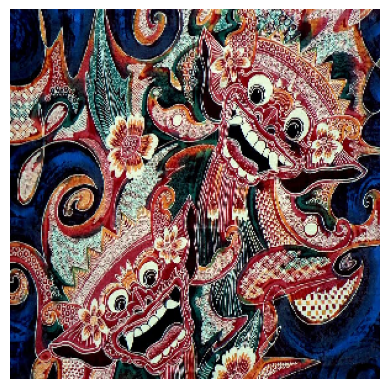

1/1 [==============================] - 0s 46ms/step
Correct Class : Bali_Barong 
Predicted Label: Bali_Barong


In [ ]:
from keras.preprocessing import image
img_target = '/content/interesting-barong-motifs-on-the-batiks-bali-glimpses-of-the-world.jpg'

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
model_input = model_Xception_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : Bali_Barong ")
print(f"Predicted Label: {class_names[img_pred]}")

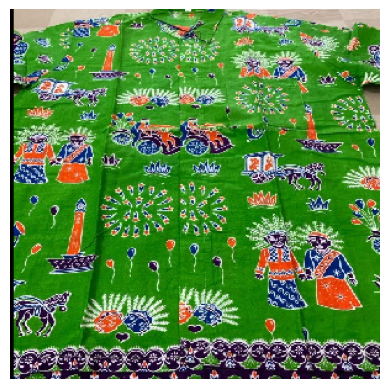

1/1 [==============================] - 0s 40ms/step
Correct Class : DKI_Ondel_Ondel 
Predicted Label: DKI_Ondel_Ondel


In [ ]:
img_target = '/content/harusnya-ondelondel.jpg'

model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : DKI_Ondel_Ondel ")
print(f"Predicted Label: {class_names[img_pred]}")

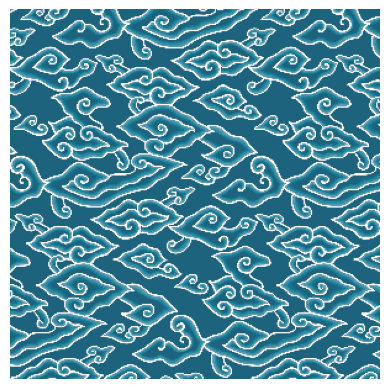

1/1 [==============================] - 0s 38ms/step
Correct Class : JawaBarat_Megamendung 
Predicted Label: JawaBarat_Megamendung


In [ ]:
img_target = '/content/harusnya-megamendung.jpg'

model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : JawaBarat_Megamendung ")
print(f"Predicted Label: {class_names[img_pred]}")

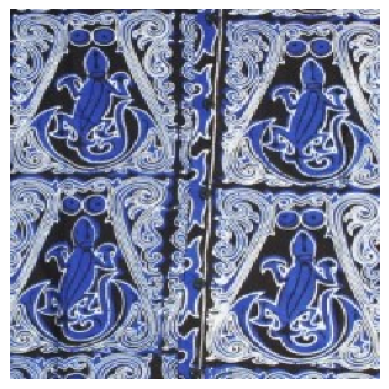

1/1 [==============================] - 0s 57ms/step
Correct Class : SumateraUtara_Boraspati 
Predicted Label: SumateraUtara_Boraspati


In [ ]:
img_target = '/content/harusnya-boraspati.jpg'

model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : SumateraUtara_Boraspati ")
print(f"Predicted Label: {class_names[img_pred]}")

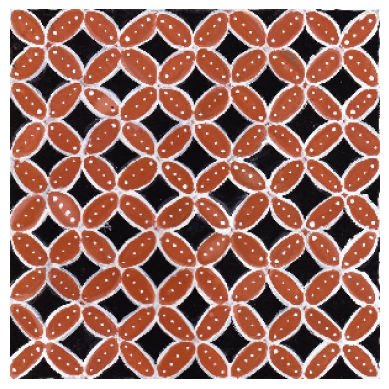

1/1 [==============================] - 0s 64ms/step
Correct Class : Yogyakarta_Kawung 
Predicted Label: Yogyakarta_Kawung


In [ ]:
img_target = '/content/harusnya-kawung.jpg'

model_input = model_ENB3_BEST

img_resized = image.load_img(img_target, target_size=(300, 300))


plt.imshow(img_resized)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img_resized)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


img_pred = np.argmax(model_input.predict(img_array))

# Menampilkan hasil prediksi
print(f"Correct Class : Yogyakarta_Kawung ")
print(f"Predicted Label: {class_names[img_pred]}")

#Convert JSON

In [ ]:
pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 703.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
   

In [ ]:
!tensorflowjs_converter --input_format=keras /content/raw_batik_v2.1_Xception_epoch_78.h5 /content/model_Xception_2.1/

2024-06-02 19:22:52.443820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import os
import zipfile

# Path to the directory or file you want to zip
source_path = '/content/model_Xception_2.1'

# Path to save the zip file
zip_file_path = '/content/model_Xception_15_val90.zip'

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    # Write the contents of the directory or file to the zip file
    if os.path.isdir(source_path):
        for foldername, subfolders, filenames in os.walk(source_path):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                zipf.write(file_path, os.path.relpath(file_path, source_path))
    else:
        zipf.write(source_path, os.path.basename(source_path))

print("Zip file created successfully:", zip_file_path)

Zip file created successfully: /content/model_Xception_15_val90.zip
